# Ungraded Lab: Build a Multi-output Model

In this lab, we'll show how you can build models with more than one output. The dataset we will be working on is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Energy+efficiency). It is an Energy Efficiency dataset which uses the bulding features (e.g. wall area, roof area) as inputs and has two outputs: Cooling Load and Heating Load. Let's see how we can build a model to train on this data.

## Imports

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split

## Utilities

We define a few utilities for data conversion and visualization to make our code more neat.

In [2]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2


def norm(x):
    return (x - train_stats['mean']) / train_stats['std']


def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

## Prepare the Data

We download the dataset and format it for training.

In [20]:
# Specify data URI
URI = 'local_data/ENB2012_data.xls'

# link for dataset excel: https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx


# Use pandas excel reader
df = pd.read_excel(URI)

# df.drop(columns=['Unnamed: 10', 'Unnamed: 11'], inplace=True)


In [21]:
df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


In [22]:

df = df.sample(frac=1).reset_index(drop=True)

# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()

# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)

In [23]:
train

,X1,X2,X3,X4,X5,X6,X7,X8
232,0.71,710.5,269.5,220.50,3.5,2,0.25,4
198,0.79,637.0,343.0,147.00,7.0,4,0.25,2
721,0.98,514.5,294.0,110.25,7.0,5,0.25,2
262,0.66,759.5,318.5,220.50,3.5,4,0.40,5
549,0.98,514.5,294.0,110.25,7.0,4,0.40,4
...,...,...,...,...,...,...,...,...
358,0.71,710.5,269.5,220.50,3.5,3,0.40,3
195,0.82,612.5,318.5,147.00,7.0,3,0.10,3
703,0.64,784.0,343.0,220.50,3.5,5,0.10,1
564,0.74,686.0,245.0,220.50,3.5,3,0.10,2


## Build the Model

Here is how we'll build the model using the functional syntax. Notice that we can specify a list of outputs (i.e. `[y1_output, y2_output]`) when we instantiate the `Model()` class.

In [24]:
# Define model layers.
input_layer = Input(shape=(len(train .columns),))
first_dense = Dense(units='128', activation='relu')(input_layer)
second_dense = Dense(units='128', activation='relu')(first_dense)

# Y1 output will be fed directly from the second dense
y1_output = Dense(units='1', name='y1_output')(second_dense)
third_dense = Dense(units='64', activation='relu')(second_dense)

# Y2 output will come via the third dense
y2_output = Dense(units='1', name='y2_output')(third_dense)

# Define the model with the input layer and a list of output layers
model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 128)          1152        input_2[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 128)          16512       dense_3[0][0]                    
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 64)           8256        dense_4[0][0]                    
____________________________________________________________________________________________

## Configure parameters

We specify the optimizer as well as the loss and metrics for each output.

In [25]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(lr=0.001)
model.compile(optimizer=optimizer,
              loss={'y1_output': 'mse', 'y2_output': 'mse'},
              metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(),
                       'y2_output': tf.keras.metrics.RootMeanSquaredError()})

## Train the Model

In [26]:
# Train the model for 500 epochs
history = model.fit(norm_train_X, train_Y,
                    epochs=10, batch_size=10, validation_data=(norm_test_X, test_Y))

Epoch 1/10
62/62 [==============================] - 1s 4ms/step - loss: 558.3519 - y1_output_loss: 261.8806 - y2_output_loss: 296.4713 - y1_output_root_mean_squared_error: 15.6448 - y2_output_root_mean_squared_error: 16.5897 - val_loss: 35.3501 - val_y1_output_loss: 17.6830 - val_y2_output_loss: 17.6671 - val_y1_output_root_mean_squared_error: 4.2051 - val_y2_output_root_mean_squared_error: 4.2032
Epoch 2/10
62/62 [==============================] - 0s 1ms/step - loss: 34.7343 - y1_output_loss: 12.9546 - y2_output_loss: 21.7797 - y1_output_root_mean_squared_error: 3.5948 - y2_output_root_mean_squared_error: 4.6486 - val_loss: 33.6444 - val_y1_output_loss: 15.4094 - val_y2_output_loss: 18.2350 - val_y1_output_root_mean_squared_error: 3.9255 - val_y2_output_root_mean_squared_error: 4.2702
Epoch 3/10
62/62 [==============================] - 0s 1ms/step - loss: 32.2030 - y1_output_loss: 11.5578 - y2_output_loss: 20.6452 - y1_output_root_mean_squared_error: 3.3915 - y2_output_root_mean_squar

## Evaluate the Model and Plot Metrics

In [9]:
# Test the model and print loss and mse for both outputs
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

9/9 [==============================] - 0s 1ms/step - loss: nan - y1_output_loss: nan - y2_output_loss: nan - y1_output_root_mean_squared_error: nan - y2_output_root_mean_squared_error: nan
Loss = nan, Y1_loss = nan, Y1_mse = nan, Y2_loss = nan, Y2_mse = nan


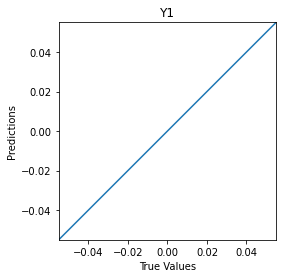

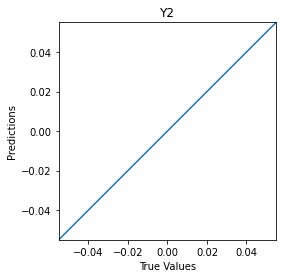

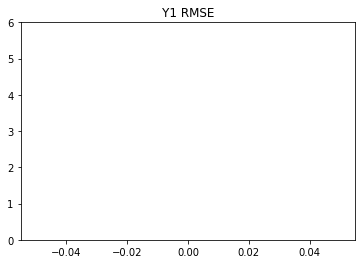

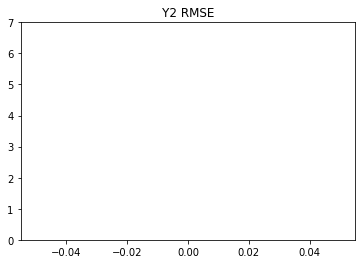

In [10]:
# Plot the loss and mse
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)